In [286]:
%pylab inline


from __future__ import division
from scipy.integrate import quad
from copy import copy, deepcopy
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt


class demandFunc():
    
    def __init__(self,**params):
        for key in params:
                setattr(self, key, params[key])

    def demand(self, P):
        return self.multiplier*P**-self.elasticity
    
    def invDemand(self, Q):
        return (self.multiplier/Q)**(1/self.elasticity)

    def demandCurve(self, Pvec):
        '''
        Pvec is a vector of prices
        '''
        return map(self.demand, Pvec)
    
    def invDemandCurve(self, Qvec):
        '''
        Qcev is a vector of quantities
        '''
        return map(self.invDemand, Qvec)
        
        
class supplyFunc():

    def __init__(self,interval_points):
        '''
        interval points is a set of tupples (Q,P)
        '''
        self.interval_points = copy(interval_points)
        
        
    def supply(self,P):

        self.interval_points.sort(reverse=True)
        highest_q = self.interval_points[0][0]
        for q,p in self.interval_points:
            if p > P:
                highest_q = q
                continue
            if p <= P:
                return highest_q
        return highest_q
            
    def invSupply(self, Q):
        
        self.interval_points.sort(reverse=True)        
        highest_p = self.interval_points[0][1]
        for q,p in self.interval_points:
            if q < Q:
                return p
            if q >= Q:
                highest_p = p
                continue
        return highest_p

    def supplyCurve(self, Pvec):
        '''
        Pvec is a vector of prices
        '''
        return map(self.supply, Pvec)
    
    def invSupplyCurve(self, Qvec):
        '''
        Qvec is a vector of quantities
        '''
        return map(self.invSupply, Qvec)
    
class market(object):
    
    def __init__(self, demandFunc, supplyFunc):
        self.demandFunc, self.supplyFunc = demandFunc, supplyFunc
        '''
        if ad < az:
            raise ValueError('Insufficient demand.')
        '''
        self.findEQ()
    
    def findEQ(self):
        "Return equilibrium price"
        self.ranges = ((1,10))
        optimalFunc = lambda q : np.abs(self.demandFunc.invDemand(q) - self.supplyFunc.invSupply(q))
        results = optimize.brute(optimalFunc, (self.ranges, ), full_output=True,
                              finish=optimize.fmin)
        self.equilibriumQ = results[0][0]
        self.equilibriumP = self.demandFunc.invDemand(self.equilibriumQ)

        self.results = results
    '''    
    def consumer_surp(self):
        "Compute consumer surplus"
        # == Compute area under inverse demand function == #
        integrand = lambda x: (self.ad/self.bd) - (1/self.bd)* x
        area, error = quad(integrand, 0, self.quantity())
        return area - self.price() * self.quantity()
    
    def producer_surp(self):
        "Compute producer surplus"
        #  == Compute area above inverse supply curve, excluding tax == #
        integrand = lambda x: -(self.az/self.bz) + (1/self.bz) * x
        area, error = quad(integrand, 0, self.quantity())  
        return (self.price() - self.tax) * self.quantity() - area
    '''

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [361]:
stepPoints = [(0,2),(3,4),(6,9)]
demand_paramaters = {'multiplier':6,'elasticity':.7}
supplyFunction = supplyFunc(stepPoints)
demandFunction = demandFunc(**demand_paramaters)
Market = market(demandFunction,supplyFunction)


In [466]:
class scenarioSimulator(object):
    
    def __init__(self, market,grid=np.linspace(1,10,300)):
        self.market     = market
        self.grid       = grid
        self.demandPlot = market.demandFunc.invDemandCurve(grid)
        self.supplyPlot = market.supplyFunc.invSupplyCurve(grid)
    
    def plotDemand(self,ax):
        return ax.plot(self.grid, self.demandPlot, lw=2, alpha=0.6, label='demand')
    
    def plotSupply(self,ax):
        return ax.plot(self.grid, self.supplyPlot, lw=2, alpha=0.6, label='supply')
    
    def plotSupplyShift(self,ax,supplyShift=None):
        self.supplyShiftMarket = deepcopy(self.market)
        self.supplyShiftMarket.supplyFunc.interval_points = [(i,j+supplyShift) for i,j in self.market.supplyFunc.interval_points] 
        self.supplyShiftMarket.findEQ()
        self.supplyShiftPlot = self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid)
        return ax.plot(self.grid, self.supplyShiftPlot, lw=2, alpha=0.6, label='new supply')
    
    def plotDemandShift(self,ax,demandShift=None):
        self.demandShiftMarket = deepcopy(self.market)
        self.demandShiftMarket.demandFunc.multiplier += demandShift
        self.demandShiftMarket.findEQ()
        self.demandShiftPlot = self.demandShiftMarket.demandFunc.invDemandCurve(self.grid)
        return ax.plot(self.grid, self.demandShiftPlot, lw=2, alpha=0.6, label='new demand')
    
    def drawSupplyShift(self,shift=1):
        
        self.drawBasicPlot(supplyShift=shift)
    
    def drawDemandShift(self,shift=1):
        
        self.drawBasicPlot(demandShift=shift)
    
    def drawBasicPlot(self, showSurplus=True, supplyShift = None, demandShift = None):
        
        titlefont = {
                'family' : 'serif',
                'color'  : 'black',
                'weight' : 'bold',
                'size'   : 16,
                }

        labelfont = {
                'family' : 'sans-serif',  # (cursive, fantasy, monospace, serif)
                'color'  : 'black',       # html hex or colour name
                'weight' : 'normal',      # (normal, bold, bolder, lighter)
                'size'   : 14,            # default value:12
                }
        
        fig = plt.figure()
        ax = fig.add_subplot(111)

        self.plotDemand(ax)
        self.plotSupply(ax)
        if supplyShift:
            self.plotSupplyShift(ax,supplyShift=supplyShift)
        if demandShift:
            self.plotDemandShift(ax,demandShift=demandShift)
        if showSurplus:
            self.drawSurplus(ax)
            self.drawDemandSurplusChange(ax, demandShift=demandShift)
            self.drawSupplySurplusChange(ax, supplyShift=supplyShift)
        
        self.supplyShiftMarket, self.demandShiftMarket = None, None
        
        plt.title('Water Supply and Demand', fontdict=titlefont) 
        plt.xlabel('Quantity of Water', fontdict=labelfont)
        plt.ylabel('Price ($/mcm)', fontdict=labelfont)
        ax.legend(loc='upper right', frameon=False, fontsize=14)
        show()
        fig.clf

    def drawSurplus(self,ax):
        try:
            return ax.fill_between(self.grid,self.market.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid), where = self.market.demandFunc.invDemandCurve(grid) > self.market.equilibriumP, color='grey', alpha='0.5')
        except AttributeError:
            pass
        
    def drawSupplySurplusChange(self,ax,supplyShift=None):
        try:
            if supplyShift >= 0:
                return ax.fill_between(self.grid,self.market.demandFunc.invDemandCurve(self.grid), self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid), where = self.market.demandFunc.invDemandCurve(self.grid) > self.supplyShiftMarket.equilibriumP, color='blue', alpha='0.5')        
            else:  
                return ax.fill_between(self.grid,self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid), np.minimum(self.market.supplyFunc.invSupplyCurve(self.grid), self.market.demandFunc.invDemandCurve(self.grid)), where = self.market.demandFunc.invDemandCurve(self.grid) > self.supplyShiftMarket.equilibriumP, color='blue', alpha='0.5')        
        except AttributeError:
            pass
        
    def drawDemandSurplusChange(self,ax,demandShift=None):
        try:
            if demandShift >= 0:
                return ax.fill_between(self.grid,self.demandShiftMarket.demandFunc.invDemandCurve(self.grid), np.maximum(self.market.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid)),  where = self.demandShiftMarket.demandFunc.invDemandCurve(self.grid) > self.demandShiftMarket.equilibriumP,color='blue', alpha='0.5')        
            else:
                return ax.fill_between(self.grid,self.market.demandFunc.invDemandCurve(self.grid), np.maximum(self.demandShiftMarket.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid)), where = self.market.demandFunc.invDemandCurve(self.grid) > self.market.equilibriumP, color='blue', alpha='0.5')        
        except AttributeError:
            pass

In [467]:
graphing = scenarioSimulator(Market)

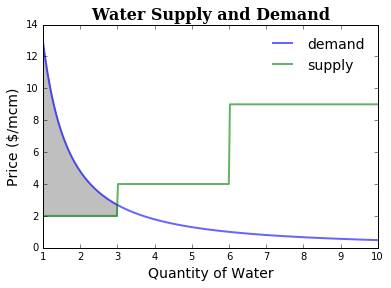

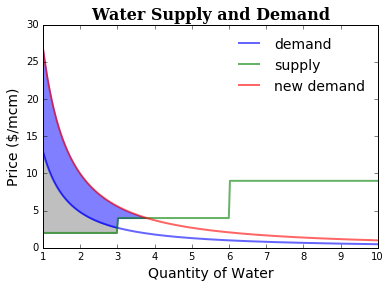

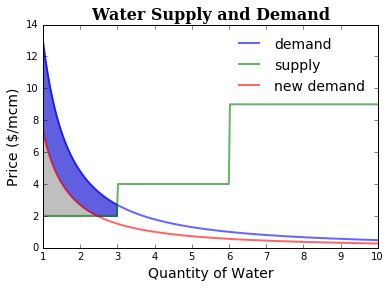

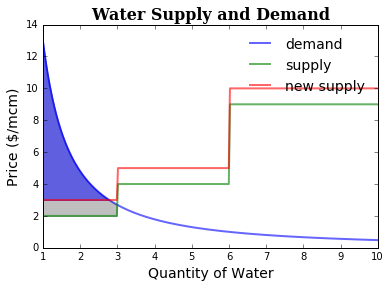

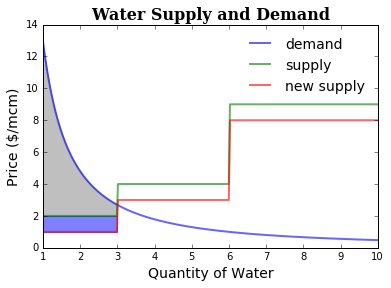

In [472]:
graphing.drawBasicPlot()

graphing.drawDemandShift(4)
graphing.drawDemandShift(-2)

graphing.drawSupplyShift()
graphing.drawSupplyShift(-1)
